# Initial thoughts 
### Things done well:
- This was my first proper ML project where I achieved a high accuracy compared to my peers
- I spent a high amount of time on the project and it really started my passion for ML#
- I learnt many skills such as handling different types of data, data processing, trying and improving different models, tf-idf, dimensionality reduction

### Improvements:
- I spent most of the time trying to increasing my training score as high as possible which is bad as this clearly leads to overfitting
- My inital data exploration and subsquent visualisations were poor
- I used a bazaar versioning system rather than Jupyter notebooks
- I didnt structure my work very well and the explainations were more a stream of thoughts. 

# We start again

## Frame the problem
The problem is that we want to be able to take a tweet about a live news story and give a classification as to whether the contents of the message is real or fake. Such a system would be used by a news company to increase their confidence that any tweets they post in their articles are geniune. 

A current system would require a journalist to go through each individual tweet and make a decision themselves. With this system a list of refined real tweets could be presented to the journalist.

It is a supervised offline classification problem where the perfromance is measured by F1 score - the higher the score the more we can trust that a tweet classified as real is a genuine source that can be included in a report

I do have my previous system that I could reuse but I won't as in this project I am not looking for high performance but rather a well strucuted notebook with insights and graphs that give reason to my decision making. The only expertise available is my own real world experince of using twitter and seeing how fake tweets are often used by trolls. 

The minimum perfromance needed to add value is unknown, if we can produce a system that 9/10 gives a correct prediction then this is likely to be useful. 

The project contains tweet text data for which there are similiar projects avaible that could be looked at for inspiration.


## Get the data

Data is provided as part of the coursework. The data is real world tweets collected about Hurricane Sandy that hit the US in late 2012

## Explore the data

In [141]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [142]:
data_raw = pd.read_csv("data/mediaeval-2015-trainingset.txt", sep='\t')

In [143]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


Straight away we can see all of the columns and that it appears we do not have any null vlaues. We have two int columns (tweetId and userId) and then 5 object columns. Both int columns are Id's so there is limited (if any) data inspection we can do here. We could look for duplicates

In [144]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_raw, data_raw["label"]):
    strat_train_set = data_raw.loc[train_index]
    strat_test_set = data_raw.loc[test_index]

In [145]:
num_attribs = ['tweetId', 'userId']
obj_attribs = [x for x in data_raw.columns if x not in num_attribs]

In [146]:
users_with_more = data_raw['userId'].value_counts().where(lambda x : x > 1).dropna()
print(users_with_more)

139189262     16.0
834560797     10.0
357078809      9.0
89221442       8.0
2623669827     8.0
              ... 
392302245      2.0
464045416      2.0
339187255      2.0
244344102      2.0
31322164       2.0
Name: userId, Length: 551, dtype: float64


There are 551 users that appear more than once but will not include 'userId' as a training attribute. This makes sense as this could lead to a model overfitting in the real world. For instance if the model learns that one users tweets are always real and then in practice the system has a fake input from this user it could get passed to the journalist and defeat the goal of the system. However, it could be argued that identifying accounts that are reputable sources or not could be used, this would have to be something to go back to the product owner to discuss. 

We will also look at tweetId in a similar way

In [147]:
tweets_with_more = data_raw['tweetId'].value_counts().where(lambda x : x > 1).dropna()
tweetIds = tweets_with_more.keys().tolist()
print(tweets_with_more)
print(tweetIds)

264736470089216000    2.0
263351427320131584    2.0
Name: tweetId, dtype: float64
[264736470089216000, 263351427320131584]


In [148]:
print(data_raw[data_raw['tweetId'].isin(tweetIds)])

                  tweetId                                          tweetText  \
2439   264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   
7744   263351427320131584            Ground Zero #Sandy http://t.co/KA1jNv3I   
7821   263351427320131584            Ground Zero #Sandy http://t.co/KA1jNv3I   
11947  264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   

         userId      imageId(s)      username                       timestamp  \
2439    2675041  sandyB_fake_11         cDima  Sat Nov 03 14:31:07 +0000 2012   
7744   15933769  sandyA_real_04  AngelaYvonne  Tue Oct 30 18:47:27 +0000 2012   
7821   15933769  sandyA_real_04  AngelaYvonne  Tue Oct 30 18:47:27 +0000 2012   
11947   2675041  sandyB_real_54         cDima  Sat Nov 03 14:31:07 +0000 2012   

      label  
2439   fake  
7744   real  
7821   real  
11947  real  


The 'Ground zero' tweets are identical with both having 'real' labels. However, for the 'Lower Manhattan's' tweets one is real and one is fake; the only difference is their imageId(s). We can gain insight here that some of the imageId's actually contain the correct label for the tweet. We can make a feature out of this.

In [149]:
data_raw = data_raw.drop_duplicates()
print(data_raw[data_raw['tweetId'].isin(tweetIds)])

                  tweetId                                          tweetText  \
2439   264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   
7744   263351427320131584            Ground Zero #Sandy http://t.co/KA1jNv3I   
11947  264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   

         userId      imageId(s)      username                       timestamp  \
2439    2675041  sandyB_fake_11         cDima  Sat Nov 03 14:31:07 +0000 2012   
7744   15933769  sandyA_real_04  AngelaYvonne  Tue Oct 30 18:47:27 +0000 2012   
11947   2675041  sandyB_real_54         cDima  Sat Nov 03 14:31:07 +0000 2012   

      label  
2439   fake  
7744   real  
11947  real  


We have removed the one duplicate entry and let the two tweets with different imageId(s). It would be useful to look at the users with multiple tweets to see if they tend to be true or fake tweets

In [150]:
data_raw.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


<AxesSubplot:>

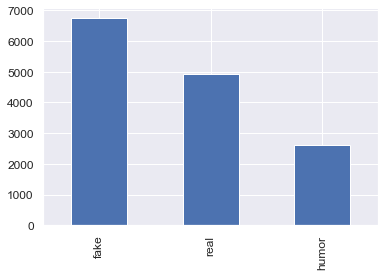

In [151]:
import seaborn as sns

data_raw['label'].value_counts().plot(kind='bar')

<AxesSubplot:>

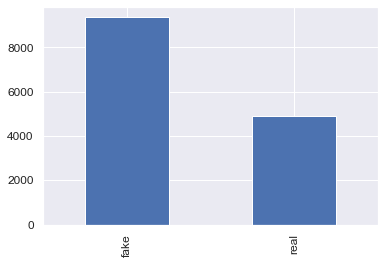

In [152]:
data_raw['label'] = data_raw['label'].replace({'humor':'fake'})
data_raw['label'].value_counts().plot(kind='bar')

Removed the 'humor' label as from the project specification we do not want to predict this label so the entries with this label have been cast to fake as the as specified by the requirement. We can see from the counts of the fake and real labels that we do have a very skewed dataset. This would be something to look into (TODO)

<AxesSubplot:xlabel='username', ylabel='count'>

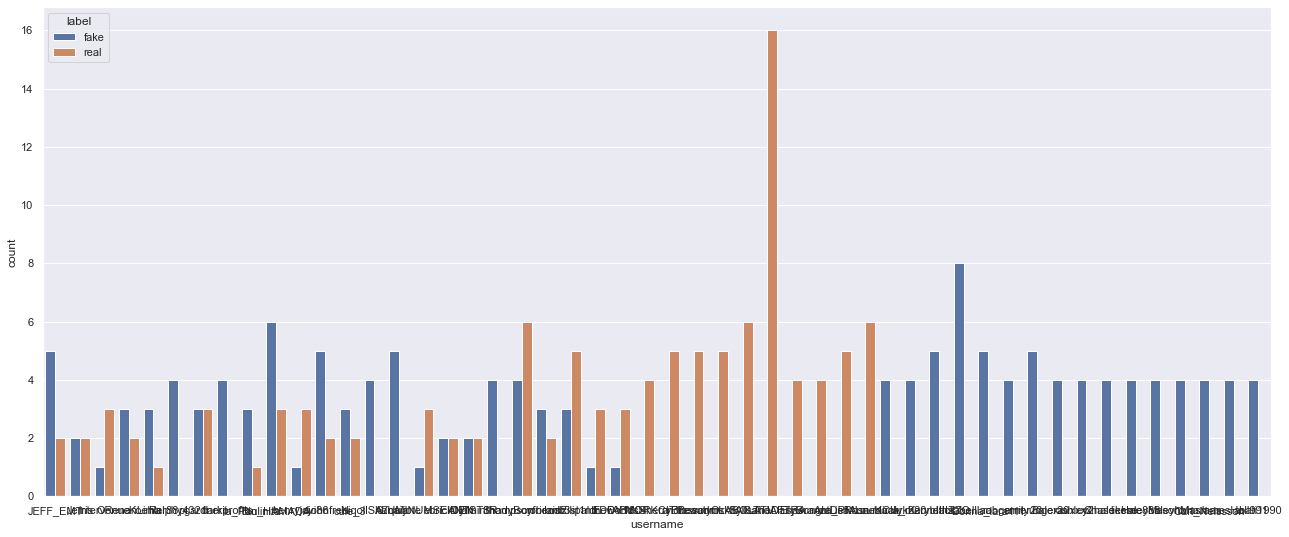

In [153]:
freq_users = data_raw.groupby('username').filter(lambda x : len(x) > 3)
freq_users.head()


sns.set(rc={'figure.figsize':(22,9)})
sns.countplot(x="username", hue='label', data=freq_users)

The userId's arent visible but we can see that some users (those with more than tweets in the dataset) do tweet completely either fake or real tweets but there are mixed accounts. I'm undecided if we should keep username in the dataset, this would be something to go back to the product owners on. We can drop userId as, by definition, it is purely a unique id for that user. We can also drop 'tweetId' as from context of the problem the Id of a tweet has no relation to its context and therefore if it is real or not. To stop the number of features growing too much, we will not include the userId/username features. 

In [154]:
data_raw = data_raw.drop(columns=['tweetId', 'userId'])
print(data_raw.columns)

Index(['tweetText', 'imageId(s)', 'username', 'timestamp', 'label'], dtype='object')


Now be interesting to see how we could use timestamp. Do tweets are a certain time be more likely to be fake or real? Do fake tweets come in a large dump or do real and fake tweets happen simulataneously as we are looking at tweets about real time events? 

In [155]:
# example: Tue Mar 11 23: 59: 22 +0000 2014
# Mon Oct 29 20:46:02 +0000 2012

print(data_raw['timestamp'])

0          Mon Oct 29 22:34:01 +0000 2012
1          Mon Oct 29 19:11:23 +0000 2012
2          Mon Oct 29 18:11:08 +0000 2012
3          Mon Oct 29 19:15:33 +0000 2012
4          Mon Oct 29 20:46:02 +0000 2012
                       ...               
14272    Tue Mar 11 03: 48: 36 +0000 2014
14273    Mon Mar 10 18: 09: 26 +0000 2014
14274    Mon Mar 10 10: 59: 45 +0000 2014
14275    Sun Mar 09 20: 07: 10 +0000 2014
14276    Sun Mar 09 16: 36: 09 +0000 2014
Name: timestamp, Length: 14276, dtype: object


These are going to be quite difficult to handle so I will look to come back to them. I would look to bin the time of the day, day of the week, month. These are unlikely, in this context, to have much bearing on whether a tweet is real or fake but would definetly be interesting to investigate. I will drop the column for now until I have a basic model up and running then if the perfromance is not high enough then I will come back

In [156]:
data_raw = data_raw.drop(columns=['timestamp'])
print(data_raw.head())

                                           tweetText      imageId(s)  \
0  ¿Se acuerdan de la película: “El día después d...  sandyA_fake_46   
1  @milenagimon: Miren a Sandy en NY!  Tremenda i...  sandyA_fake_09   
2  Buena la foto del Huracán Sandy, me recuerda a...  sandyA_fake_09   
3     Scary shit #hurricane #NY http://t.co/e4JLBUfH  sandyA_fake_29   
4  My fave place in the world #nyc #hurricane #sa...  sandyA_fake_15   

         username label  
0         iAnnieM  fake  
1  CarlosVerareal  fake  
2     LucasPalape  fake  
3     Haaaaarryyy  fake  
4  princess__natt  fake  


In [157]:
print(data_raw.columns)

Index(['tweetText', 'imageId(s)', 'username', 'label'], dtype='object')


Will now move onto imageId to split on '_'s as the label is often in the middle

In [158]:
from collections import Counter
data_raw['imageMiddle'] = data_raw['imageId(s)'].str.split('_')
print(Counter([x[1] for x in data_raw['imageMiddle']]))
print(Counter([len(x) for x in data_raw['imageMiddle']]))

Counter({'fake': 9287, 'real': 4920, '02': 47, '01': 18, '03': 3, '04': 1})
Counter({3: 14078, 5: 121, 2: 69, 7: 6, 9: 1, 11: 1})


The majority of imageId(s)'s do contain the world real or fake but not all. Also, not all contain underscores and if they do they are of different lengths. To solve this we could build a function that checks if the imageId contains the word real or fake and then have that as the column, if it contains neither then have a default value. 

In [159]:
def map_image_id(id: str):
    if "real" in id:
        return "real"
    elif "fake" in id:
        return "fake"
    else:
        return "neither"

In [160]:
data_raw['image_label'] = data_raw['imageId(s)'].apply(lambda row: map_image_id(row))
print(data_raw['image_label'].value_counts())

fake       9287
real       4920
neither      69
Name: image_label, dtype: int64


<AxesSubplot:xlabel='image_label', ylabel='count'>

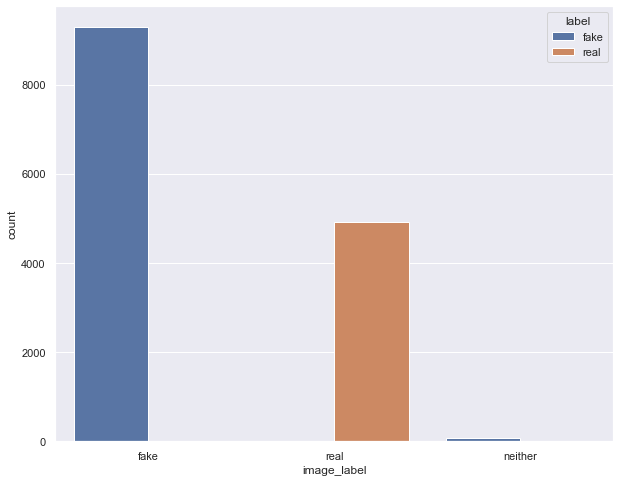

In [161]:
sns.set(rc={'figure.figsize':(10,8)})
sns.countplot(x="image_label", hue='label', data=data_raw)

We can see that this feature is almost directly related to the label.

The only problem here is that we are removing all other information from the imageId that could be potentially be useful such as the event ('sandy').
NEXT STAGE - can we generate a column that has more than fake and real. FIRST need to compare if the labels directly map to the result. 

In [162]:
parts = [p for x in data_raw['imageId(s)'].str.split('_').to_list() for p in x if not p.isnumeric()]
c = Counter(parts)
print(c)

Counter({'sandyA': 9695, 'fake': 9397, 'real': 4950, 'sandyB': 2622, 'boston': 546, 'malaysia': 501, 'sochi': 402, 'columbianChemicals': 185, 'bringback': 131, 'underwater': 112, '03,boston': 99, 'passport': 46, 'pigFish': 14, 'elephant': 13, '06,boston': 12, 'livr': 9, '01,boston': 7, '04,boston': 6, '16,boston': 5, '02,boston': 4, '07,boston': 2, '05,boston': 1, '10,boston': 1, '24,boston': 1, '18,boston': 1, '27,boston': 1, '1fake': 1})


In [163]:
to_del = ['real', 'fake']
for x, count in c.items():
    if 'boston' in x and not x == 'boston':
        c['boston'] += count
        to_del.append(x)
    elif count < 20:
        to_del.append(x)

c = {x: count for x, count in c.items() if x not in to_del}
print(c)

{'sandyA': 9695, 'sandyB': 2622, 'boston': 686, 'columbianChemicals': 185, 'bringback': 131, 'passport': 46, 'underwater': 112, 'sochi': 402, 'malaysia': 501}


After a bit of filtering we can see that although there are a high value of fake and real labels in the images but there are also a high numner of location based labels = [sandyA, sandyB, boston, sochi, malaysia]. We can create another column for location as well as real/fake, THEN do a plot to see how these new features correspond to real/fake labels. 

In [164]:
def map_image_place(id: str):
    if "sandyA" in id:
        return "sandyA"
    elif "sandyB" in id:
        return "sandyB"
    elif "boston" in id:
        return "boston"
    elif "sochi" in id:
        return "sochi"
    elif "malaysia" in id:
        return "malaysia"
    else:
        return "none"

In [165]:
data_raw['image_place'] = data_raw['imageId(s)'].apply(lambda row: map_image_place(row))
print(data_raw['image_place'].value_counts())

sandyA      9695
sandyB      2622
boston       546
none         510
malaysia     501
sochi        402
Name: image_place, dtype: int64


<AxesSubplot:xlabel='image_place', ylabel='count'>

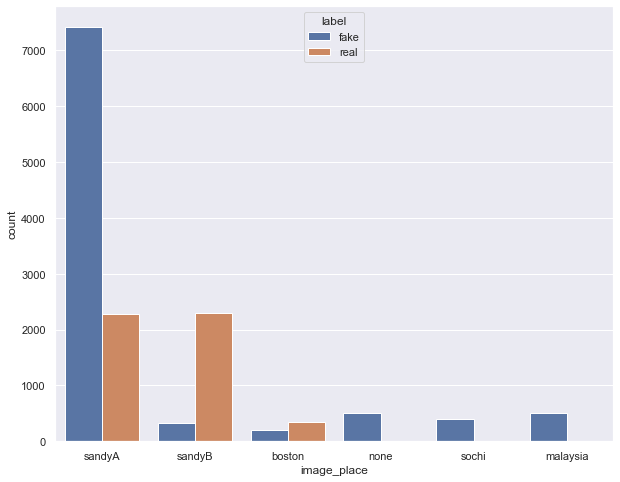

In [166]:
sns.countplot(x="image_place", hue='label', data=data_raw)

Again this new feature looks to be very usefull, every new catergory seems to be very telling. We can also map the values that are not sandyA/B or boston as all other categories contain only fake tweets. 

In [167]:
def map_image_place2(id: str):
    if "sandyA" in id:
        return "sandyA"
    elif "sandyB" in id:
        return "sandyB"
    elif "boston" in id:
        return "boston"
    else:
        return "none"

In [168]:
data_raw['image_place'] = data_raw['imageId(s)'].apply(lambda row: map_image_place2(row))
print(data_raw['image_place'].value_counts())

sandyA    9695
sandyB    2622
none      1413
boston     546
Name: image_place, dtype: int64


<AxesSubplot:xlabel='image_place', ylabel='count'>

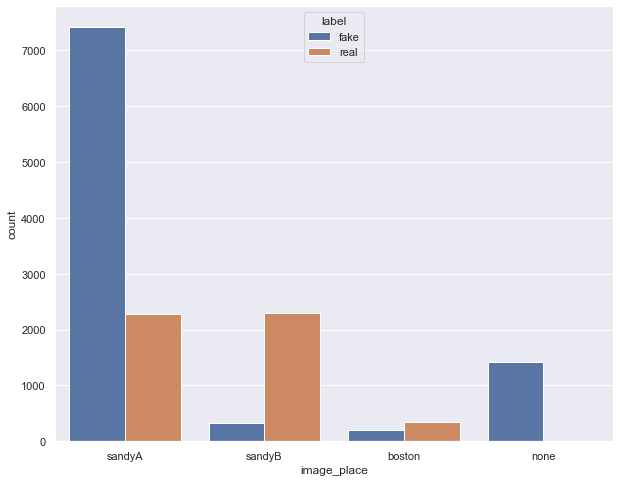

In [169]:
sns.countplot(x="image_place", hue='label', data=data_raw)

If we create a model from just the above two features with XGBoost how good is the model. Is it even worth adding in the text data? In the context of a real world example then we would as the images won't always be labeled in this way so we should start with a model on these labels and then move on to handling the tweet text data

In [170]:
data_raw.columns

Index(['tweetText', 'imageId(s)', 'username', 'label', 'imageMiddle',
       'image_label', 'image_place'],
      dtype='object')

In [171]:
# create a transformer to add convert the image labels and return a dataframe with them in

def map_image_place(id: str):
    if "sandyA" in id:
        return "sandyA"
    elif "sandyB" in id:
        return "sandyB"
    elif "boston" in id:
        return "boston"
    else:
        return "none"

def map_image_label(id: str):
    if "real" in id:
        return "real"
    elif "fake" in id:
        return "fake"
    else:
        return "neither"


from sklearn.base import BaseEstimator, TransformerMixin

class SeparateImageIdInfoAdder(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        image_place = X['imageId(s)'].apply(lambda row: map_image_place(row))
        image_label = X['imageId(s)'].apply(lambda row: map_image_label(row))
        return np.c_[X, image_place, image_label]


class HumorLabelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        label = data_raw['label'].replace({'humor':'fake'})
        return np.c_[X, label]


In [172]:
imageAdder = SeparateImageIdInfoAdder()
sep_image_attribs = imageAdder.transform(strat_train_set)

In [173]:
data_extra_attribs = pd.DataFrame(sep_image_attribs, 
    columns=list(strat_train_set.columns) + ["image_place", "image_label"],
    index=strat_train_set.index)
data_extra_attribs.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,image_place,image_label
1058,263116481687085056,#PrayForUSA #Sandy http://t.co/XzfGgCGX,263774008,sandyA_fake_29,waraujo1983,Tue Oct 30 03:13:52 +0000 2012,fake,sandyA,fake
13105,464848098859048960,Cele4love2007:Let's get it on! Act 1 Scene 1! ...,354742896,bringback_fake_04,cele4love2007,Fri May 09 19:23:17 +0000 2014,fake,none,fake
1591,262999083365588992,Waiting for #Sandy to make landfall. Three hou...,23613932,sandyA_fake_17,fer_twitts,Mon Oct 29 19:27:22 +0000 2012,fake,sandyA,fake
13968,448061307724378112,Malaysia Airlines ad a few years ago! Ironic T...,1029798690,malaysia_fake_21,nurani49v,Mon Mar 24 11:38:35 +0000 2014,fake,none,fake
1215,263250268861370369,#sandy #newyork ¬ http://t.co/ilv9a2NN (via @J...,35703535,sandyA_fake_23,PaulinaStrange,Tue Oct 30 12:05:29 +0000 2012,fake,sandyA,fake


We have our transformer to add in our new features but we also need a transformer to drop the ones we don't need (username, userId, imageId, tweetId, timestamp)

In [174]:
class DropColumns(BaseEstimator, TransformerMixin):

    def __init__(self):
        super().__init__()

    def fit(self, X, y = None):
        return self

    def transform(self, X:pd.DataFrame, drop_cols):
        keep_cols = [col for col in X.columns if col not in drop_cols]
        return X.copy()[keep_cols]

In [175]:
def add_drop_columns(df, drop_cols):
    imageAdder = SeparateImageIdInfoAdder()
    sep_image_attribs = imageAdder.transform(df)
    data_extra_attribs = pd.DataFrame(sep_image_attribs, 
        columns=list(df.columns) + ["image_place", "image_label"],
        index=df.index)
    dropper = DropColumns()
    data_stripped = dropper.transform(data_extra_attribs, drop_cols)
    return data_stripped

In [176]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def transform_dataframe(df, drop_cols, hot_encoder, label_encoder, test=False):
    

    df['label'] = df['label'].replace({'humor':'fake'})
    data_labels = df["label"].copy()

    df = add_drop_columns(df, drop_cols)
    df = df.drop("label", axis=1)

    if not test:
        X = hot_encoder.fit_transform(df[["image_place", "image_label"]])
        y = label_encoder.fit_transform(data_labels)
    else:
        X = hot_encoder.transform(df[["image_place", "image_label"]])
        y = label_encoder.transform(data_labels)

    return X, y


In [177]:
drop_cols = ["tweetId", "tweetText", "userId", "imageId(s)", "timestamp", "username"]
oneHot = OneHotEncoder()
label = LabelEncoder()

train_X, train_y = transform_dataframe(strat_train_set, drop_cols, oneHot, label)
test_X, test_y = transform_dataframe(strat_test_set, drop_cols, oneHot, label)

# Fitting first model on very simple data

In [178]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(train_X, train_y)

SVC()

In [179]:
from sklearn.metrics import f1_score, accuracy_score
pred = svc.predict(test_X)
print(pred)
print(test_y)
print(f1_score(test_y, pred))
print(accuracy_score(test_y, pred))

[1 1 0 ... 1 1 0]
[1 1 0 ... 1 1 0]
1.0
1.0


It appears this model is perfect, but this seems to good to be true, which mean it probably is... Will need to look into it and find out why

In [181]:
print(train_y)
print(test_y)

[0 0 0 ... 0 0 0]
[1 1 0 ... 1 1 0]


I think it might be as 100% as the image label often does contain the true label and if not the city it contains can be used with fairly high accuracy to predict. Therefore I think this is a poor challenge and I think I should spend my time looking at another challenge. I hope to come back to this project with more experience to truley identify if there is a bug or if the model is 100% accurate - this could be done with using cross validation and not using stratified split data. 